In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from pathlib import Path
path = Path('datasets\cta-ridership-daily-boarding-totals.csv')
df = pd.read_csv(path , parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis = 1)
df = df.drop_duplicates()

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [4]:
df.describe()

,bus,rail
count,6.755000e+03,6.755000e+03
mean,7.990159e+05,5.726775e+05
std,2.313009e+05,1.788232e+05
min,1.241540e+05,8.799200e+04
25%,6.112195e+05,4.232585e+05
50%,8.761110e+05,6.203430e+05
75%,9.885210e+05,7.152315e+05
max,1.211992e+06,1.146516e+06


array([[<Axes: title={'center': 'bus'}>,
        <Axes: title={'center': 'rail'}>]], dtype=object)

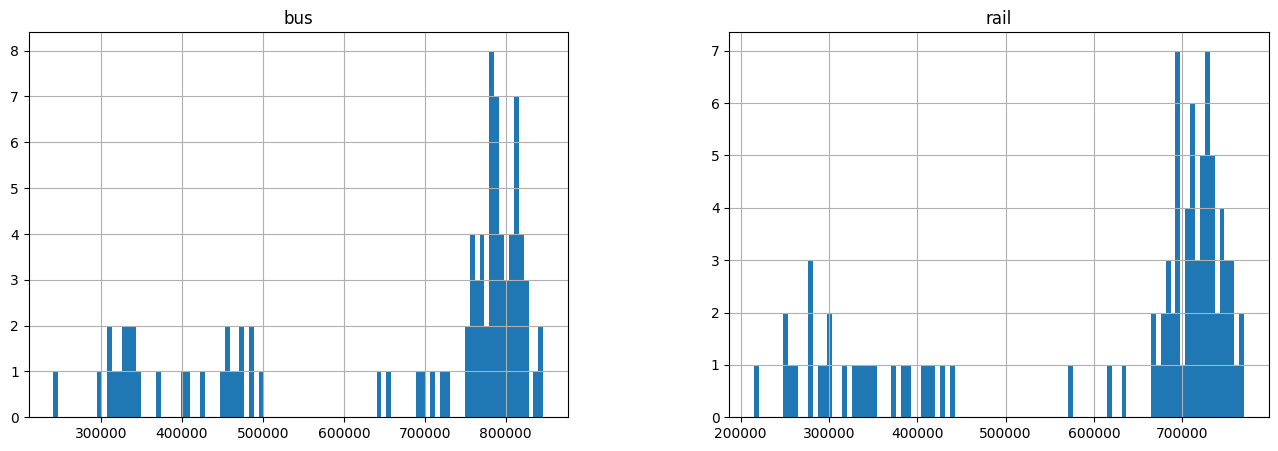

In [5]:
df['2019-03':'2019-05'].hist(bins = 100, figsize= (16,5))

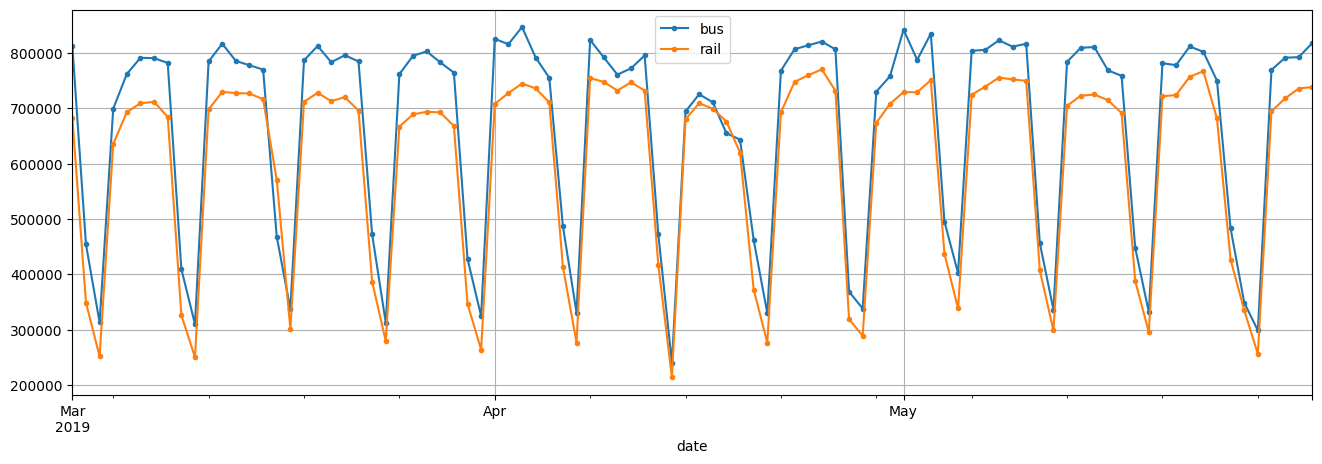

In [6]:
df['2019-03':'2019-05'].plot(grid = True, marker = '.', figsize = (16, 5))
plt.show()

In [7]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-3':'2019-5']

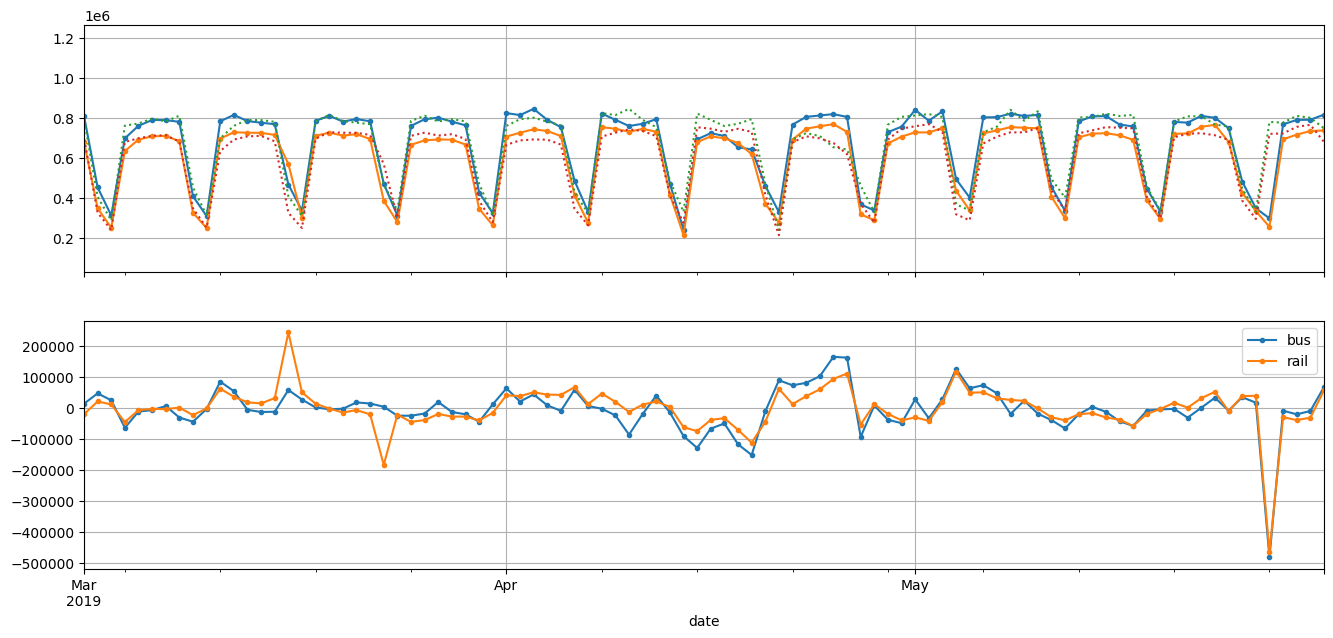

In [8]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (16,8))
df.plot(ax = axs[0], legend = False , marker = '.')
df.shift(7).plot(ax = axs[0], grid = True, legend = False, linestyle = ':')
diff_7.plot(ax = axs[1], grid = True, marker = '.')
plt.show()

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[['bus', 'rail']]['2019-3': '2019-5']

In [11]:
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

C:\Users\isthi\AppData\Local\Temp\ipykernel_8732\2778962719.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[['bus', 'rail']].resample('M').mean()


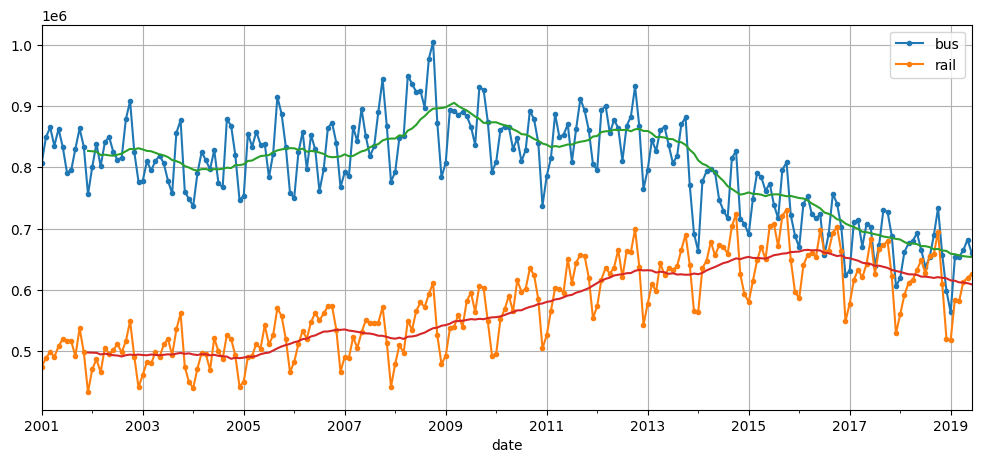

In [12]:
period = slice('2001', '2019')
df_monthly = df[['bus', 'rail']].resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window = 12).mean()

fig , ax = plt.subplots(figsize=(12,5))
df_monthly[period].plot(ax = ax, marker = '.')
rolling_average_12_months.plot(ax = ax, grid = True , legend =False)
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
origin , today = '2019-01-01' , '2019-5-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(rail_series, 
              order = (1,0,0),
              seasonal_order = (0,1,1,7))
model = model.fit()
y_pred = model.forecast()

In [15]:
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

In [16]:
rail_train = df['rail']['2016 - 01':'2018-12']/ 1e6
rail_vail = df['rail']['2019-01':'2019-05']/ 1e6
rail_test = df['rail']['2019-01':'2019-05']/ 1e6

In [17]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_vail.to_numpy(),
    targets = rail_vail[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences= True, input_shape = [None,1]),
    tf.keras.layers.SimpleRNN(32, return_sequences= True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9),
              metrics = ['mae']
              )

In [20]:
history = model.fit(train_ds , validation_data= valid_ds , epochs = 500, callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mae',
                                                            patience = 50,
                                                            restore_best_weights = True)])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1414 - mae: 0.3763 - val_loss: 0.0036 - val_mae: 0.0587
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - mae: 0.0742 - val_loss: 0.0026 - val_mae: 0.0480
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - mae: 0.0653 - val_loss: 0.0025 - val_mae: 0.0466
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - mae: 0.0603 - val_loss: 0.0024 - val_mae: 0.0427
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - mae: 0.0569 - val_loss: 0.0023 - val_mae: 0.0425
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - mae: 0.0611 - val_loss: 0.0036 - val_mae: 0.0624
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - mae: 0.0552 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - mae: 0.0543 - val_loss: 0.0029 - val_mae: 0.0537
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

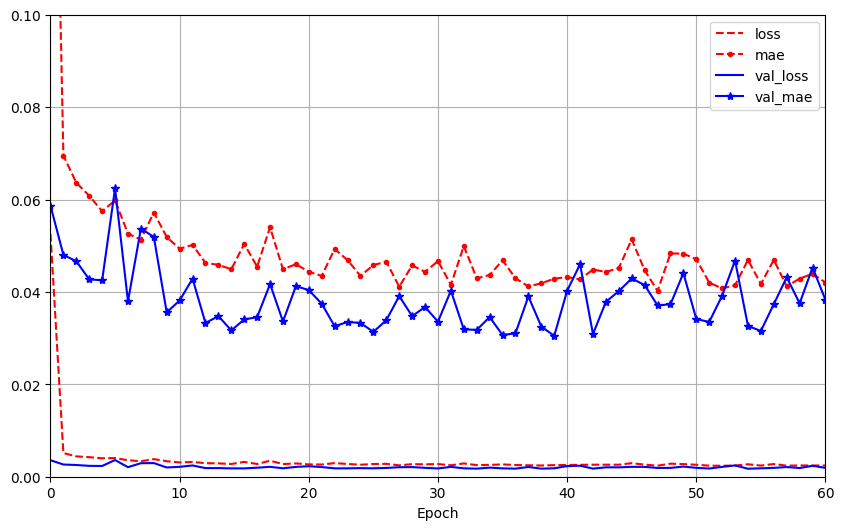

In [21]:
pd.DataFrame(history.history).plot(figsize = (10, 6), xlim = [0,60], ylim = [0,0.1], grid =True, xlabel = 'Epoch', style = ['r--', 'r--.', 'b-', 'b-*'])
plt.show()

In [22]:
model.evaluate(valid_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0274     


[0.0016815802082419395, 0.02881650999188423]

In [23]:
val_pred = model.predict(valid_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


## Predicting several timesteps ahead in sequences

In [24]:
df_multivar = df[['bus', 'rail']]/ 1e6
df_multivar['next_day_type'] = df['day_type'].shift(-1)
df_multivar = pd.get_dummies(df_multivar)

In [25]:
multivar_train  = df_multivar['2016-01': '2018-12']
multivar_valid = df_multivar['2019-01': '2019-05']
multivar_test = df_multivar['2019-06':]

In [26]:
def split_targets(multivar_series , targets_ahead = 14, target_col = 1):
    return multivar_series[:, :-targets_ahead] , multivar_series[: , -targets_ahead: , target_col]

In [27]:
train_multivar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy().astype(np.float32),
    targets = None,
    sequence_length = seq_length + 14,
    batch_size = 32,
    shuffle = True,
    seed  = 42
).map(split_targets)

In [44]:
valid_multivar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_valid.to_numpy().astype(np.float32),
    targets = None,
    sequence_length = seq_length + 14,
    batch_size = 32
).map(split_targets)

In [45]:
TimeStepsForecast = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences= True, input_shape = [None,5]),
    tf.keras.layers.SimpleRNN(32, return_sequences= True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(14)
])

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
TimeStepsForecast.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9),
              metrics = ['mae'])

In [47]:
for x, y in train_multivar_ds.take(1):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)


Input shape: (32, 56, 5)
Target shape: (32, 14)


In [49]:
historymulti_var = TimeStepsForecast.fit(train_multivar_ds , validation_data= valid_multivar_ds, epochs = 500,
                                         callbacks = [tf.keras.callbacks.EarlyStopping( monitor = 'val_mae',
                                                                                       patience = 50,
                                                                                       restore_best_weights = True)])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1754 - mae: 0.4606 - val_loss: 0.0181 - val_mae: 0.1466
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168 - mae: 0.1473 - val_loss: 0.0121 - val_mae: 0.1192
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0122 - mae: 0.1266 - val_loss: 0.0091 - val_mae: 0.1029
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0098 - mae: 0.1090 - val_loss: 0.0075 - val_mae: 0.0938
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081 - mae: 0.0957 - val_loss: 0.0047 - val_mae: 0.0735
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - mae: 0.0825 - val_loss: 0.0032 - val_mae: 0.0614
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - mae: 0.0778 - val_loss: 0.0030 - val_mae: 0.0600
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - mae: 0.0689 - val_loss: 0.0021 - val_mae: 0.0489
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

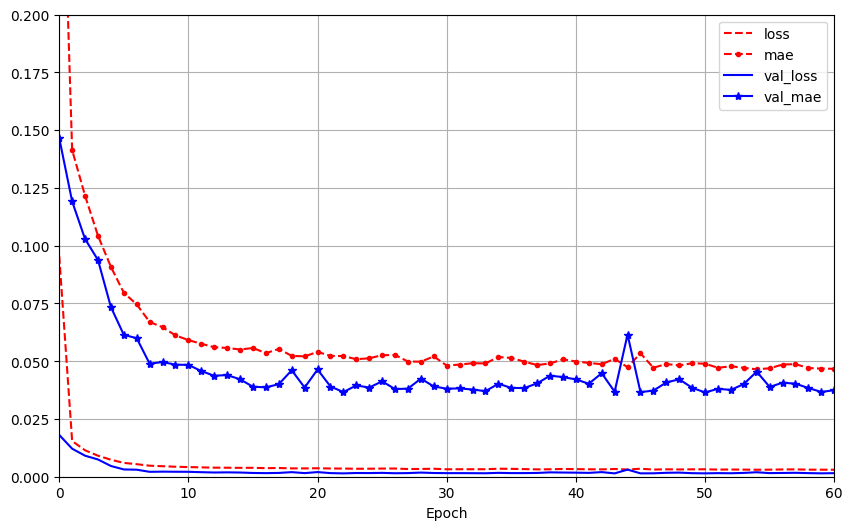

In [52]:
pd.DataFrame(historymulti_var.history).plot(figsize = (10, 6), xlim = [0,60], ylim = [0,0.2], grid =True, xlabel = 'Epoch', style = ['r--', 'r--.', 'b-', 'b-*'])
plt.show()